# A-Band Fitting Using HAPI MultiSpectrum fitting
* Loads packages
* Defines Spectra and Dataset
* Generates parameter and baseline linelists
* Fits Data

In [1]:
## Multi- Spectrum Fitting by Segment

import numpy as np
import pandas as pd
import qgrid
import os, sys
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

sys.path.append(r'C:\Users\ema3\Documents\MATS\MATS')# set location of HAPI.py module

from hapi import *
from MATS import *

import seaborn as sns
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("poster")


HAPI version: 1.1.0.9.6
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005


## Load Spectrum

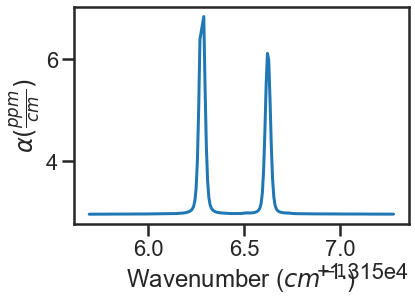

In [2]:
path = r'C:\Users\ema3\Documents\MATS\MATS\Examples\A-Band - Experimental Spectra'
os.chdir(path)

#Generic Fit Parameters
wave_range = 1.5 #range outside of experimental x-range to simulate
IntensityThreshold = 1e-30 #intensities must be above this value to be simulated
Fit_Intensity = 1e-24 #intensities must be above this value for the line to be fit
order_baseline_fit = 1
tau_column = 'Corrected Tau (us)' # Mean tau/us
freq_column = 'Total Frequency (Detuning)' # Total Frequency /MHz
pressure_column = 'Cavity Pressure /Torr'
temperature_column = 'Cavity Temperature Side 2 /C'


#Define all Spectra individually
spec_1 = Spectrum('190510_2per_43_forfit', 
                        molefraction = { 7 :0.01949}, natural_abundance = True, diluent = 'air', 
                        etalons = {1:[0.001364, 1.271443]}, 
                        input_freq = True, frequency_column = freq_column,
                        input_tau = True, tau_column = tau_column, tau_stats_column = None, 
                        pressure_column = pressure_column, temperature_column = temperature_column, 
                        nominal_temperature = 296, x_shift = 0.00)
spec_2 = Spectrum('190510_2per_55_forfit', 
                        molefraction = { 7 : 0.01949}, natural_abundance = True, diluent = 'air', 
                        etalons = {1:[0.001364, 1.271443]}, 
                        input_freq = True, frequency_column = freq_column,
                        input_tau = True, tau_column = tau_column, tau_stats_column = None, 
                        pressure_column = pressure_column, temperature_column = temperature_column, 
                        nominal_temperature = 296, x_shift = 0.00)
spec_3 = Spectrum('190513_2per_82_forfit', 
                        molefraction = { 7 :0.01949}, natural_abundance = True, diluent = 'air', 
                        etalons = {1:[0.001364, 1.271443]}, 
                        input_freq = True, frequency_column = freq_column,
                        input_tau = True, tau_column = tau_column, tau_stats_column = None, 
                        pressure_column = pressure_column, temperature_column = temperature_column, 
                        nominal_temperature = 296, x_shift = 0.00)
spec_4 = Spectrum('190514_2per_126_forfit', 
                        molefraction = { 7 :0.01949}, natural_abundance = True, diluent = 'air', 
                        etalons = {1:[0.001364, 1.271443]}, 
                        input_freq = True, frequency_column = freq_column,
                        input_tau = True, tau_column = tau_column, tau_stats_column = None, 
                        pressure_column = pressure_column, temperature_column = temperature_column, 
                        nominal_temperature = 296, x_shift = 0.00)



spec_1.plot_wave_alpha()



## Construct Dataset

In [3]:
#Add all spectrum to a Dataset object
SPECTRA = Dataset([spec_1, spec_2, spec_3, spec_4], 'Line Intensity', baseline_order = order_baseline_fit)

#Generate Baseline Parameter list based on number of etalons in spectra definitions and baseline order
BASE_LINELIST = SPECTRA.generate_baseline_paramlist()
#BASE_LINELIST = pd.read_csv('Line Intensity_baseline_paramlist.csv')

#Read in Possible linelists
hapi = r'C:\Users\ema3\Documents\MATS\MATS\Linelists'
os.chdir(hapi)
PARAM_LINELIST = pd.read_csv('O2_ABand_Drouin_2017_linelist.csv')



## Generate Fit Parameter Files

In [4]:
os.chdir(path)
# Set-up for Fitting
#lineprofile = 'NGP' #VP, SDVP, NGP, SDNGP, HTP


  

FITPARAMS = Generate_FitParam_File(SPECTRA, PARAM_LINELIST, BASE_LINELIST, lineprofile = 'SDVP', linemixing = False, 
                                  fit_intensity = Fit_Intensity, threshold_intensity = IntensityThreshold, sim_window = wave_range,
                                  nu_constrain = False, sw_constrain = False, gamma0_constrain = True, delta0_constrain = True, 
                                   aw_constrain = True, as_constrain = True, 
                                   nuVC_constrain = True, eta_constrain =True, linemixing_constrain = True)

FITPARAMS.generate_fit_param_linelist_from_linelist(vary_nu = {7:{1:True, 2:False, 3:False}}, vary_sw = {7:{1:True, 2:False, 3:False}},
                                                    vary_gamma0 = {7:{1: True, 2:False, 3: False}, 1:{1:False}}, vary_n_gamma0 = {7:{1:True}}, 
                                                    vary_delta0 = {7:{1: False, 2:False, 3: False}, 1:{1:False}}, vary_n_delta0 = {7:{1:True}}, 
                                                    vary_aw = {7:{1: True, 2:False, 3: False}, 1:{1:False}}, vary_n_gamma2 = {7:{1:False}}, 
                                                    vary_as = {}, vary_n_delta2 = {7:{1:False}}, 
                                                    vary_nuVC = {7:{1:False}}, vary_n_nuVC = {7:{1:False}},
                                                    vary_eta = {}, vary_linemixing = {7:{1:False}})

FITPARAMS.generate_fit_baseline_linelist(vary_baseline = True, vary_molefraction = {7:False, 1:False}, vary_xshift = False, 
                                      vary_etalon_amp= True, vary_etalon_period= False, vary_etalon_phase= True)





,Pressure,Segment Number,Temperature,baseline_a,baseline_b,etalon_1_amp,etalon_1_period,etalon_1_phase,molefraction_O2,x_shift,...,etalon_1_amp_err,etalon_1_amp_vary,etalon_1_period_err,etalon_1_period_vary,etalon_1_phase_err,etalon_1_phase_vary,molefraction_O2_err,molefraction_O2_vary,x_shift_err,x_shift_vary
Spectrum Number,,,,,,,,,,,,,,,,,,,,,
1.0,0.079111,1.0,297.903746,2.957091,0.0,0.001364,1.271443,0.0,0.01949,0.0,...,0,True,0,False,0,True,0,False,0,False
2.0,0.065558,1.0,297.908245,2.959480,0.0,0.001364,1.271443,0.0,0.01949,0.0,...,0,True,0,False,0,True,0,False,0,False
3.0,0.046017,1.0,297.876303,2.956829,0.0,0.001364,1.271443,0.0,0.01949,0.0,...,0,True,0,False,0,True,0,False,0,False
4.0,0.024884,1.0,297.864910,2.949260,0.0,0.001364,1.271443,0.0,0.01949,0.0,...,0,True,0,False,0,True,0,False,0,False


Name                     Value      Min      Max   Stderr     Vary     Expr Brute_Step
Pressure_1_1           0.07911     -inf      inf        0    False     None     None
Pressure_2_1           0.06556     -inf      inf        0    False     None     None
Pressure_3_1           0.04602     -inf      inf        0    False     None     None
Pressure_4_1           0.02488     -inf      inf        0    False     None     None
SD_delta_air_line_1          0     -inf      inf        0    False     None     None
SD_delta_air_line_10         0     -inf      inf        0    False     None     None
SD_delta_air_line_13         0     -inf      inf        0    False     None     None
SD_delta_air_line_25         0     -inf      inf        0    False     None     None
SD_delta_air_line_26         0     -inf      inf        0    False     None     None
SD_gamma_air_line_1        0.1     0.01     0.25        0    False     None     None
SD_gamma_air_line_10    0.1124     0.01     0.25 0.0009002     

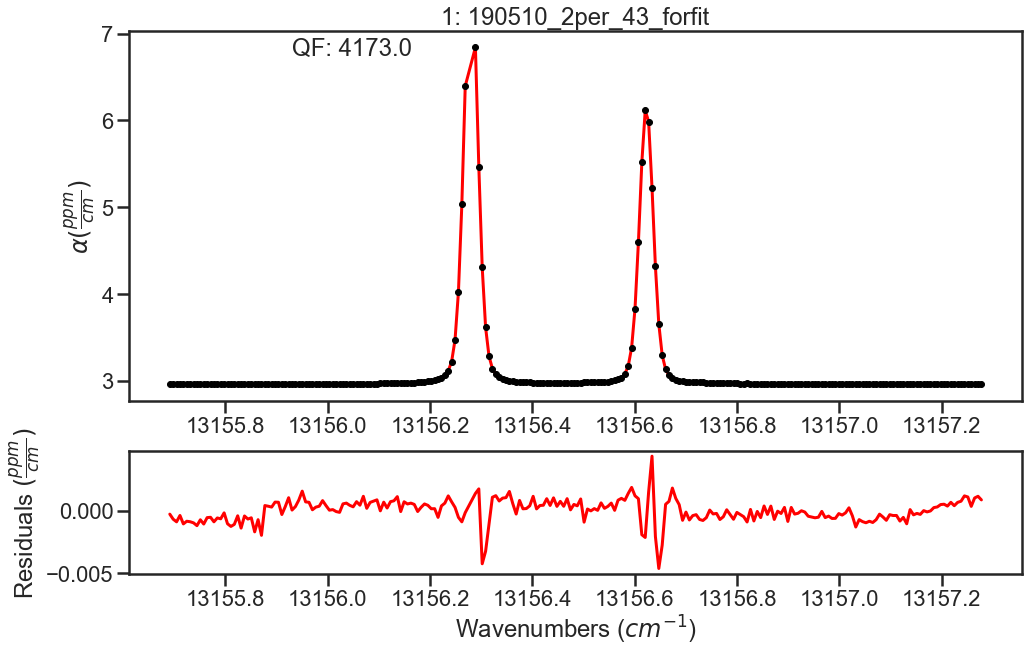

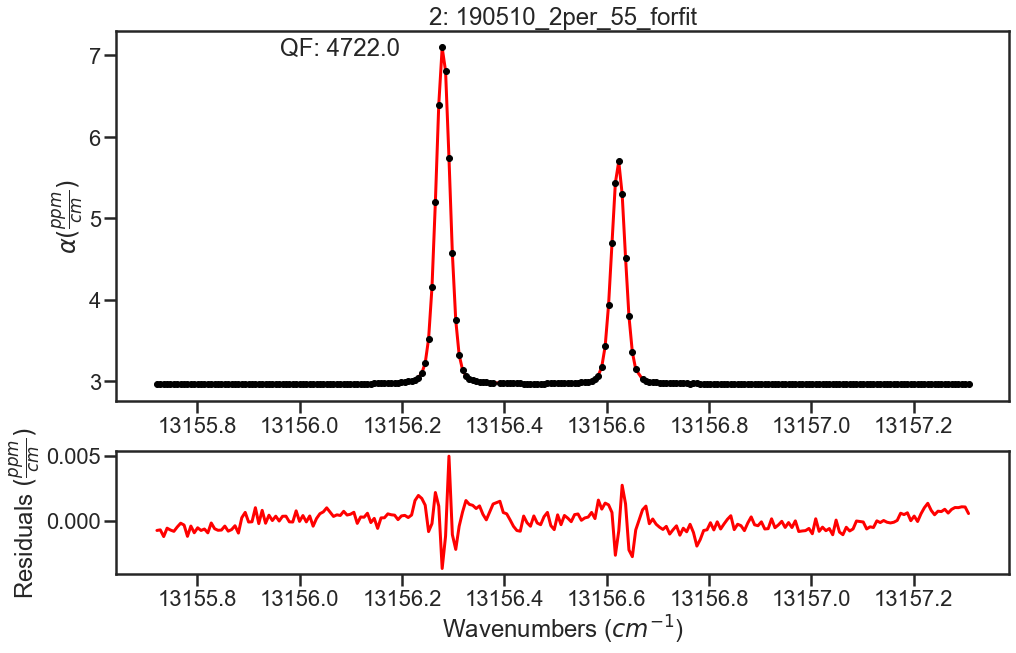

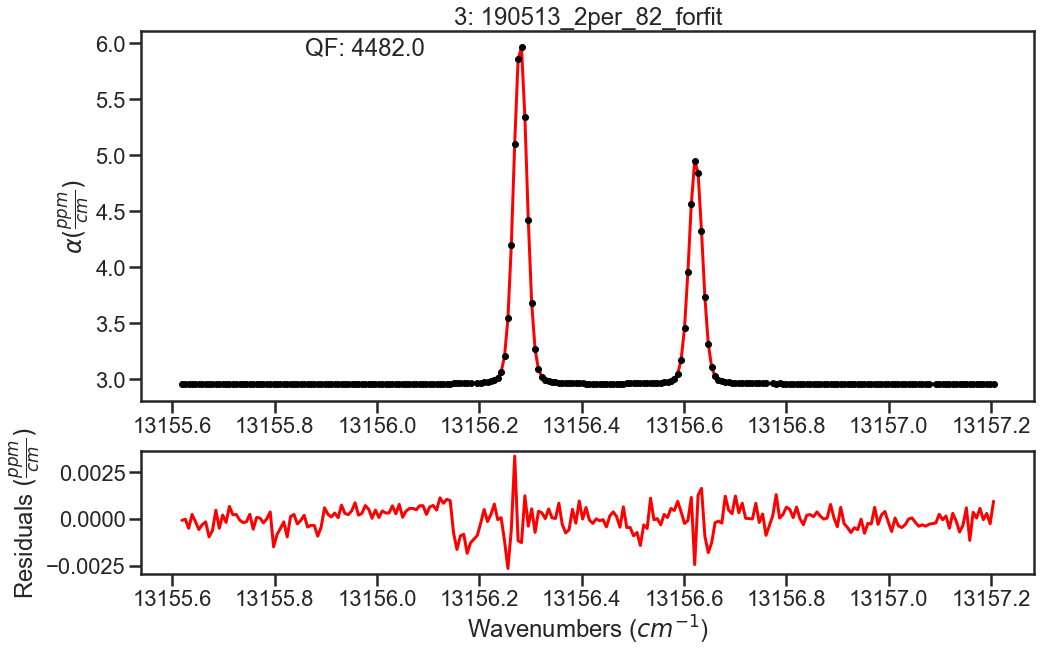

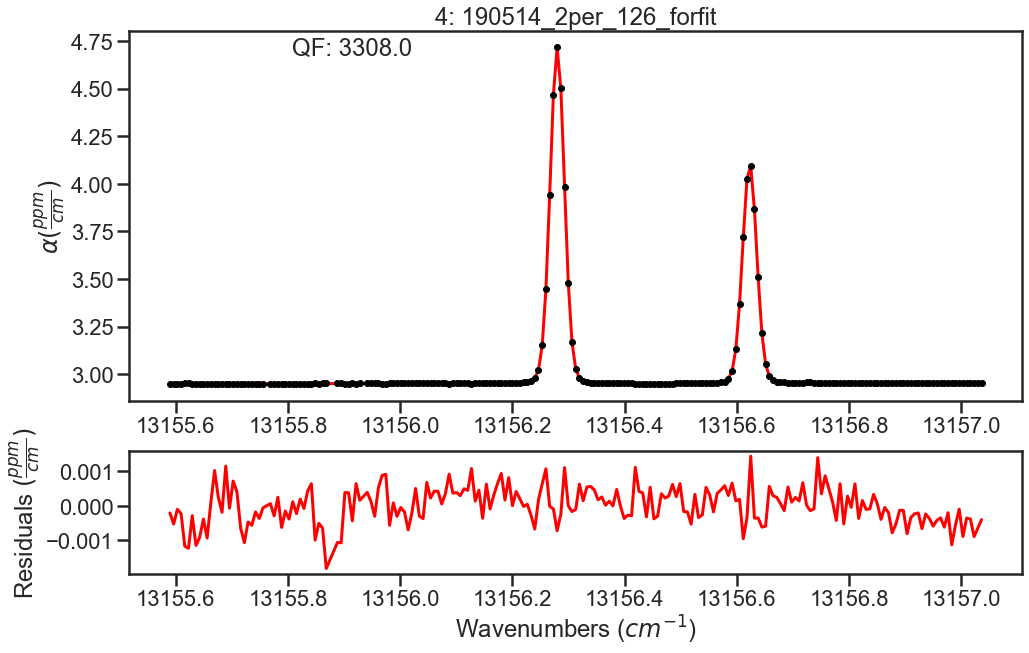

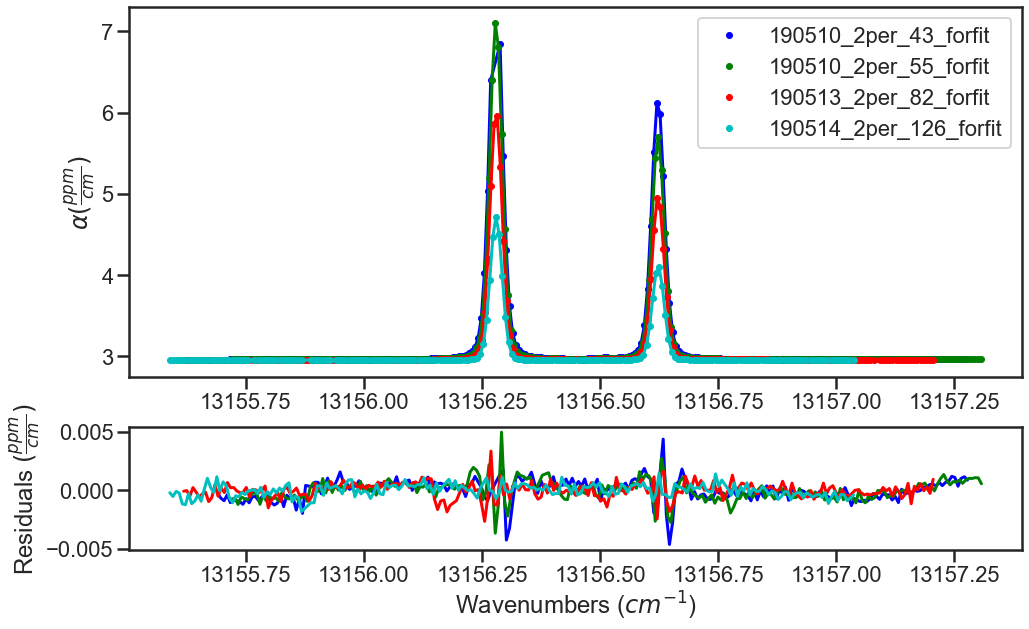

In [5]:
os.chdir(path)   
fit_data = Fit_DataSet(SPECTRA,'Baseline_LineList', 'Parameter_LineList', minimum_parameter_fit_intensity = Fit_Intensity, 
                baseline_limit = False, baseline_limit_factor = 10, 
                molefraction_limit = False, molefraction_limit_factor = 1.1, 
                etalon_limit = False, etalon_limit_factor = 2, #phase is constrained to +/- 2pi, 
                x_shift_limit = False, x_shift_limit_magnitude = 0.5, 
                nu_limit = True, nu_limit_magnitude = 0.1, 
                sw_limit = True, sw_limit_factor = 2, 
                gamma0_limit = False, gamma0_limit_factor = 3, n_gamma0_limit= False, n_gamma0_limit_factor = 50, 
                delta0_limit = False, delta0_limit_factor = 2, n_delta0_limit = False, n_delta0_limit_factor = 50, 
                SD_gamma_limit = False, SD_gamma_limit_factor = 2, n_gamma2_limit = False, n_gamma2_limit_factor = 50, 
                SD_delta_limit = False, SD_delta_limit_factor = 50, n_delta2_limit = False, n_delta2_limit_factor = 50, 
                nuVC_limit = False, nuVC_limit_factor = 2, n_nuVC_limit = False, n_nuVC_limit_factor = 50, 
                eta_limit = False, eta_limit_factor = 50, linemixing_limit = False, linemixing_limit_factor = 50)
params = fit_data.generate_params()



for param in params:
    if 'SD_gamma' in param:
        params[param].set(min = 0.01, max = 0.25)
    if 'etalon_1_amp' in param:
        if param != 'etalon_1_amp_1_1':
            params[param].set(expr='etalon_1_amp_1_1')
            
        


result = fit_data.fit_data(params, wing_cutoff = 25)
print (result.params.pretty_print())

fit_data.residual_analysis(result, indv_resid_plot=True)
fit_data.update_params(result)
SPECTRA.generate_summary_file(save_file = True)
SPECTRA.plot_model_residuals()




    Period (cm)  Amplitude     Phase  Freq (cm-1)
0      2.542886   0.000214  0.171714     0.393254
1      1.271443   0.000175 -2.956215     0.786508
2     55.307760   0.000170 -3.084972     0.018081
3      8.264378   0.000159  0.413650     0.121001
4      6.357214   0.000146  0.135360     0.157302
5     14.621592   0.000145 -3.042253     0.068392
6     38.143283   0.000143  2.264380     0.026217
7     10.807263   0.000142  3.127900     0.092530
8     35.600397   0.000141  1.102788     0.028090
9     46.407660   0.000140  0.440692     0.021548
10    33.057512   0.000136 -1.330407     0.030250
11    15.893034   0.000135 -2.563418     0.062921
12    12.078706   0.000134 -0.580023     0.082790
13    63.572138   0.000123  0.241772     0.015730
14    10.171542   0.000122  0.209013     0.098314
15    43.864775   0.000122 -1.375502     0.022797
16    41.321889   0.000122  2.473390     0.024200
17     6.992935   0.000119  2.663216     0.143001
18    47.043382   0.000116 -0.950789     0.021257


C:\Users\ema3\Documents\MATS\MATS\MATS.py:493: RuntimeWarning: divide by zero encountered in true_divide
  FFT['Freq (cm-1)'] = 1 / fft_freq
C:\Users\ema3\Documents\MATS\MATS\MATS.py:498: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1 / fft_freq, fft_amplitude, '-')


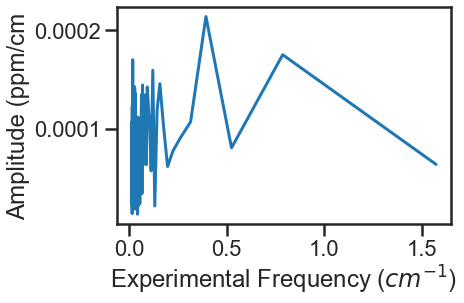

In [6]:
spec_3.fft_spectrum()